## Timeseries with LSTM

Source: https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=BKMrjozgU3I_

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

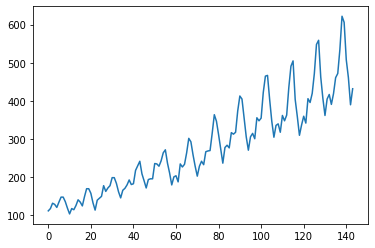

In [18]:
training_set = pd.read_csv('data/airline-passengers.csv')
#training_set = pd.read_csv('data/shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

In [19]:
print("Training Data Shape", training_set.shape)

Training Data Shape (144, 1)


In [20]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [21]:
# Normalising the Data
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

In [22]:
# Getting Data in Sequences
seq_length = 4
x, y = sliding_windows(training_data, seq_length)
print("Input Shape", x.shape)
print("Output Shape", y.shape)

Input Shape (139, 4, 1)
Output Shape (139, 1)


In [23]:
print("X: ", x[0])
print("Y: ", y[0])

X:  [[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]]
Y:  [0.03281853]


In [24]:
# Train Test Split
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size
print("Train Size:",train_size)
print("Test Size",test_size)

Train Size: 93
Test Size 46


In [25]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[:train_size])))
trainY = Variable(torch.Tensor(np.array(y[:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:])))
testY = Variable(torch.Tensor(np.array(y[train_size:])))

In [26]:
trainX.shape

torch.Size([93, 4, 1])

### LSTM Model

In [27]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [28]:
# Model Parameters
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

In [29]:
# Model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [30]:
trainX.shape

torch.Size([93, 4, 1])

In [34]:
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.00158
Epoch: 100, loss: 0.00158
Epoch: 200, loss: 0.00157
Epoch: 300, loss: 0.00157
Epoch: 400, loss: 0.00157
Epoch: 500, loss: 0.00156
Epoch: 600, loss: 0.00156
Epoch: 700, loss: 0.00156
Epoch: 800, loss: 0.00155
Epoch: 900, loss: 0.00155
Epoch: 1000, loss: 0.00154
Epoch: 1100, loss: 0.00154
Epoch: 1200, loss: 0.00152
Epoch: 1300, loss: 0.00147
Epoch: 1400, loss: 0.00146
Epoch: 1500, loss: 0.00146
Epoch: 1600, loss: 0.00145
Epoch: 1700, loss: 0.00145
Epoch: 1800, loss: 0.00144
Epoch: 1900, loss: 0.00145


In [35]:
print(" Data X Shape:", dataX.shape)
print(" Data Y Shape:", dataY.shape)

 Data X Shape: torch.Size([139, 4, 1])
 Data Y Shape: torch.Size([139, 1])


## Evaluation

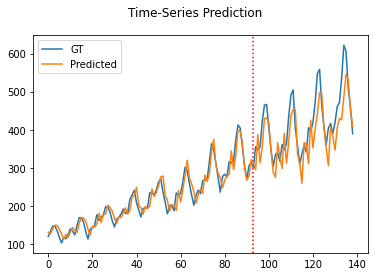

In [39]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle=':')

plt.plot(dataY_plot, label="GT")
plt.plot(data_predict, label="Predicted")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()